In [1]:
# function to calculate center coordinates of object with given label
def center(labeled_array, xrange, yrange, label):
    # find center of objects with given label
    yy, xx = np.meshgrid(yrange,xrange)
    select = labeled_array == label
    center = np.mean([xx[select],yy[select]],1)
    return center

import cv2
import matplotlib.pyplot as plt 
%matplotlib inline
import numpy as np
import matplotlib.image as mpimg
from scipy import ndimage
# importing all the required libraries
%matplotlib inline
import cv2
import warnings
warnings.filterwarnings('ignore')
import numpy as np
from skimage.transform import rotate, AffineTransform, warp
from skimage.filters import gaussian
import matplotlib.pyplot as plt
from scipy import ndimage
import skimage.measure as measure
import random
from skimage.measure import label


In [2]:
# vedio to image
vidcap = cv2.VideoCapture('data/project/robot_parcours_1.avi')
def getFrame(sec):
    vidcap.set(cv2.CAP_PROP_POS_MSEC,sec*1000)
    hasFrame,frame = vidcap.read()
#     if hasFrames:
#         cv2.imwrite("data/project/image"+str(count)+".png", image)     # Uncomment to save frame as png file(lossless)
    return hasFrame,frame
sec = 0
frameRate = 2 #//Frame rate = 2 FPS, it will capture image in each 0.5 second
count=0
hasFrame, frames = getFrame(sec)
frames = np.expand_dims(frames[:,:,::-1],0) # Indexing to convert from BGR to RGB because matplotlib decides to do it backwards
while hasFrame:
    if count > 0:
        frames = np.concatenate((frames,np.expand_dims(frame[:,:,::-1],0)),0)
    count = count + 1
    sec = round(count/frameRate, 2)
    hasFrame, frame = getFrame(sec)

In [3]:

# Segmentation red arrow
def arrowDetect(frame_input):
    frame = frame_input.copy()
    framehsv = cv2.cvtColor(~frame, cv2.COLOR_RGB2HSV) # invert image so that red becomes cyan in HSV
    lower = np.array([90-10,80,50])
    upper = np.array([90+10,255,255])

    mask = cv2.inRange(framehsv, lower, upper)
    arrow = cv2.bitwise_and(frame,frame, mask= mask)
    # Bounding box
    contours, hierarchy = cv2.findContours(arrow[:,:,2], cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key = cv2.contourArea, reverse = True)
    c = contours[0] # longest contour
    x, y, w, h = cv2.boundingRect(c)
    cv2.circle(frame, (x+w//2,y+h//2), 5, (0,255,0),-1)
    return frame, (x, y, w, h) # frame with center point shown and the four bounding box parameters

In [4]:

def trackArrow(frames_input):
    frames_output = np.zeros_like(frames_input)
    centers = np.array([]).reshape([0,2])
    for i, frame_input in enumerate(frames_input):
        frame_output, (x, y, w, h) = arrowDetect(frame_input)
        center = np.expand_dims(np.array([x+w//2, y+h//2]),0)       
        centers = np.concatenate([centers, center], 0)
        cv2.polylines(frame_output, np.int32([centers]), False, (0,255,0), thickness = 3) 
        frames_output[i] = frame_output
    return frames_output

In [5]:
frames_output = trackArrow(frames)

In [6]:
# for frame_output in frames_output:
#     plt.imshow(frame_output)
#     plt.show()

In [7]:
# plt.imshow(frames_output[0])

In [8]:
# for frame_output in frames_output:
#     plt.imshow(frame_output)
#     plt.show()

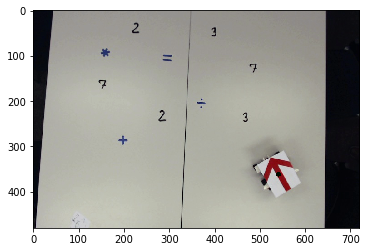

In [9]:
def whiteBalance(frame, x, y, w, h):
# White balance with white area on the robot as reference 
# (probably only needed for first frame, or can use the same ref white values for all frames)
    frameGrid = np.meshgrid(np.arange(frame.shape[1]),np.arange(frame.shape[0]))
    mask = (frameGrid[1]< y+h) & (frameGrid[1]> y) & (frameGrid[0]<x+w) & (frameGrid[0]>x)
    mask3 = np.stack([mask]*3, axis=2)
    maskedArrowBoxGray = cv2.cvtColor(frame*mask3, cv2.COLOR_RGB2GRAY)
    mask_white = cv2.threshold(maskedArrowBoxGray, maskedArrowBoxGray.max()*0.9, maskedArrowBoxGray.max(), cv2.THRESH_BINARY)[1]
    mask_white[mask_white>0] = 1
    mask_white3 = np.stack([mask_white]*3, axis=2)
    refWhite = mask_white3*frame
#     plt.imshow(refWhite)
    meanRefWhite = (np.mean(refWhite[refWhite>0].reshape([-1,3]),0)) # mean white value for reference
    lum = np.sum(meanRefWhite)/3
    framewb = frame.copy()
    framewb[:,:,0] = framewb[:,:,0] * lum / meanRefWhite[0]
    framewb[:,:,1] = framewb[:,:,1] * lum / meanRefWhite[1]
    framewb[:,:,2] = framewb[:,:,2] * lum / meanRefWhite[2]
    return framewb, meanRefWhite
frame, (x, y, w, h) = arrowDetect(frames[0])
framewb, meanRefWhite = whiteBalance(frame, x, y, w, h)
plt.imshow(framewb)

### Notes: 
Deadline: Thursday(5/7)

0. pretrain classifiers with data augmentation: digits from MNIST, operators (together (in frame0) or separate (while moving)?)
    start with diffferent colors for digit/operator, then all black for bonus (CV)
1. 1st frame: segmentation of the digits, operators --> feed segmentation results to classifiers --> classification (WJ)
    color or no color
2. Arrow(robot) tracking: subtraction(?) color segmentation(?) center to center motion between frames (MS)

3. Detect covered digit/operator: 0-8 for digits ("9" as "6"), "+, -, *, division, =" 
4. Output videso with robot tracking and equation formed until "="


In [10]:
# output video

frame_height, frame_width, _ = frame.shape

out = cv2.VideoWriter('output.avi',cv2.VideoWriter_fourcc(*'XVID'),frameRate , (frame_width,frame_height))

for frame_output in frames_output:
    out.write(frame_output[:,:,::-1])


out.release()

## 1. Predictor to recognize operators and digits (NB: "9" is not present).
Object recognition to see where they are.
MNIST Digits classifier to recognise digits. Make classifier for operators.
Use first frame to actually recognize the values inside on from this just overlap position of robot.

Old idea: From the position of "robot" (center point) see what is below him: null, digit, operator. These will return as a frame (e.g., 3, 3, 3, 6, 3) => we can therefore detect by majority that the robot is on the 3. --> more inefficient.

In [11]:
frame, (x, y, w, h) = arrowDetect(frames[0])
mainframe, meanRefWhite = whiteBalance(frame, x, y, w, h)

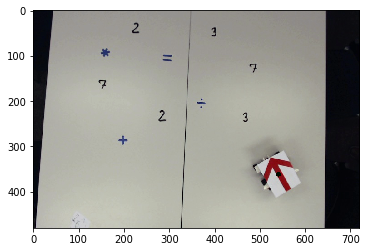

In [12]:
plt.imshow(mainframe)

## Localizate digits/operators
Ideas:
- image morphological operators (e.g. erosion)
- DL (e.g. unsupervised feature detectors)

### Segmentation with area thresholding

18


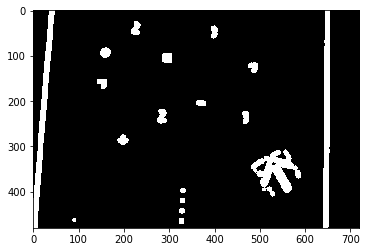

In [13]:
# Morphological operations to make objects of interest more similar to each other while different from other unwanted objects

img = cv2.cvtColor(frames[0], cv2.COLOR_RGB2GRAY)
img = cv2.GaussianBlur(img,(5,5),0)


mask1 = (1-cv2.adaptiveThreshold(img,1,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,3))
mask = ndimage.median_filter(mask1,size = 3)

kernel1 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(9,9))

mask = ndimage.median_filter(mask,size = 7)
mask = ndimage.binary_dilation(mask, structure = kernel1)

# label features
labeled_array, num_features = ndimage.label(mask)
print(num_features)


plt.imshow((mask),cmap = 'gray')
plt.show()

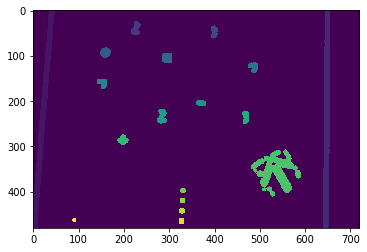

In [14]:
# labeled mask
plt.imshow(labeled_array)

In [15]:
# function to calculate center coordinates of object with given label
def center(labeled_array, xrange, yrange, label):
    # find center of objects with given label
    yy, xx = np.meshgrid(yrange,xrange)
    select = labeled_array == label
    center = np.mean([xx[select],yy[select]],1)
    return center


In [16]:
import skimage

# range of image
xrange = np.arange(mask.shape[0])
yrange = np.arange(mask.shape[1])
# center of image
c = [mask.shape[0]//2, mask.shape[1]//2]


area_list = np.zeros([num_features+1,1])
size = np.zeros([num_features+1,2])
object_id = []
object_center = []
contour_list = []

robot_center = [x+w//2, y+h//2]


# calculate areas and centers, apply threshold on area to select objects of interest
for i in range(num_features+1):
    area = np.sum(labeled_array == i)
    area_list[i] = area
    obj_center = center(labeled_array, xrange, yrange, i)
    dist = (np.sqrt(np.power(np.abs(obj_center[1]-robot_center[0]),2) + np.power(np.abs(obj_center[0]-robot_center[1]),2)))
    if (area >= 200) & (area <= 1000) & (dist >= 40): # thershold by area and distance to get objects
        object_id.append(i)
        object_center.append(obj_center)

    # get contours
    temp = np.zeros_like(labeled_array)
    temp[labeled_array == i] = 1
    contours = skimage.measure.find_contours(temp,0.8)
    contour = sorted(contours, key=lambda x: len(x))[-1] # get longest contour
    contour_list.append(len(contour))
    
print(sorted(contour_list)) # check contour length
print(sorted(area_list)) # observe that objects of interest have areas that are one order of magnitude different from others'

[37, 49, 51, 51, 55, 75, 95, 95, 97, 99, 99, 101, 103, 121, 127, 490, 518, 815, 815]
[array([57.]), array([120.]), array([132.]), array([132.]), array([156.]), array([258.]), array([355.]), array([357.]), array([381.]), array([395.]), array([396.]), array([439.]), array([453.]), array([481.]), array([520.]), array([5068.]), array([6034.]), array([6121.]), array([323745.])]


In [17]:
# crop objects with calcualted centers and bounding box size of the arrow on robot

objects = np.zeros([len(object_center),28, 28])
mask = (1-cv2.adaptiveThreshold(img,1,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,3))

for i, c in enumerate(object_center):
    y,x = c
    objects[i,:] = cv2.resize(mask[int(y-h//4):int(y+h//4), int(x-w//4):int(x+w//4)], (28, 28), interpolation = cv2.INTER_AREA)


# # plot images to check
# for im in objects:
#     plt.imshow(im, cmap = 'gray')
#     plt.show()

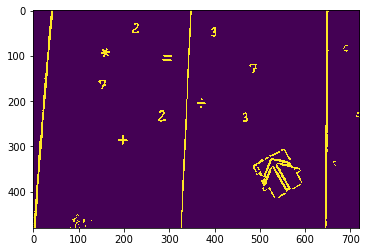

In [18]:
plt.imshow(mask)

2
51
59


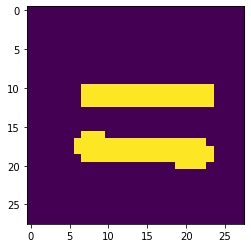

In [19]:
# import skimage  #40-100 contour??

# test = objects[3]
# plt.imshow(test)
# test2 = image.copy()
# test2 = test2*255
# test2 = 255 - cv2.adaptiveThreshold(test2.astype(np.uint8),255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,3,3)

# plt.imshow(test2)
# plt.show()
# # test2 = ndimage.median_filter(test2,size = 7)
# # test2 = ndimage.binary_dilation(test2, structure = kernel1)

# # fig, ax = plt.subplots()
# # ax.imshow(test2, cmap='gray')
# # test2 = ndimage.median_filter(test2,size = 3)

# kernel1 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(9,9))

# # test2 = ndimage.median_filter(test2,size = 7)
# test2 = ndimage.binary_dilation(test2, structure = kernel1)

# plt.imshow(test2)
# plt.show()
# print(test2.sum())

test = objects[3]
plt.imshow(test)
array, N = ndimage.label(test)
print(N)
for i in range(1,N+1):
    print((array == i).sum())

### Operators classification

In [20]:
img = cv2.imread('original_operators.png')

In [21]:
plus = img[:,0:310]
equal = img[:,340:650]
minus = img[:,710:1020]
divide = img[:,1080:1390]
multiply = img[:,1440:1750]

In [22]:
# helpers
# Convert contour into complex signals for fourier descriptor calculations
def color2bin(im):
    (_, im_bw) = cv2.threshold(cv2.cvtColor(im, cv2.COLOR_BGR2GRAY), 128, 255, cv2.THRESH_BINARY)
    im_bw = 255 - im_bw
    plt.imshow(im_bw, cmap= 'gray')
    return im_bw

def convert_signal(contour):
    output = np.zeros((np.array(contour).shape[0],1))
    output = contour[:,1] + 1j*contour[:,0] 
    return output

# Find outer contour and convert
def contour_fourier(images):
    contour_out = []
    for id, im in enumerate(images): 
        im = ndimage.binary_fill_holes(im) 
        im[im>0] = 255
        contours = measure.find_contours(im, 0)
        if len(contours) < 1:
            print(id)
            plt.imshow(im)
            plt.show()
        contour = sorted(contours, key=lambda x: len(x))[-1]
        contour_out.append(convert_signal(contour))
    return np.array(contour_out)

def get_fourier_descriptor(ims, contours, N, f1, f2, f_div):
    batch_size = ims.shape[0]//N
    batch = -1
    FD = np.zeros((N, batch_size,2))
    for ct in range(ims.shape[0]):
        if ct % batch_size == 0:
            batch += 1
        fft = np.fft.fft(contours[ct])
        # normalization
        if f_div == -1:
            FD[batch, ct % batch_size, :]  = np.abs([fft[f1],fft[f2]])  # Translaton (Exclude f0), scaling (ratio)，and rotation(amplitude) invariances

        else:
            FD[batch, ct % batch_size, :]  = np.abs([fft[f1],fft[f2]])/np.abs(fft[f_div])  # Translaton (Exclude f0), scaling (ratio)，and rotation(amplitude) invariances
    return FD

# Plot images with contours

def plotImagContour(axes, ims, contours):
    N = ims.shape[0]//axes.shape[0]
    ct =  0
    ax_id = 0
    if len(axes.shape) > 1:
        while ax_id < axes.shape[0]:
            for ax in axes[ax_id]:
                ax.imshow(ims[ct])
                ax.step(np.real(contours[ct]), np.imag(contours[ct]), linewidth=2, c='r')
                ax.axis('off')
                ct += 1
                if ct % N == 0:
                    ax_id += 1
    else: 
        for ax in axes:
            ax.imshow(ims[ct])
            ax.step(np.real(contours[ct]), np.imag(contours[ct]), linewidth=2, c='r')
            ax.axis('off')
            ct += 1
            
def operators_augmentation(im, rot_step):
    out_ims =  np.array([]).reshape(0, im.shape[0], im.shape[1])
    for rot in np.arange(0, 360 + rot_step, rot_step):
        s =  random.uniform(0.99, 1.01)
        tform = AffineTransform(scale=(s, s))
        im_tf = warp(im, tform.inverse, output_shape=im.shape)
        rotated = rotate(im_tf, angle=rot, mode = 'constant',cval = 0)

        rotated[rotated>0.4] = 1
        rotated[rotated<=0.4] = 0
        rotated = np.expand_dims(rotated, 0)

        out_ims = np.concatenate((out_ims, rotated),0)
    return out_ims

(316, 310)


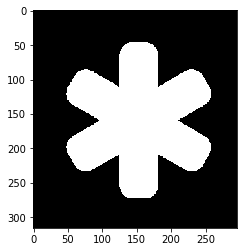

In [23]:
plus_bw = color2bin(plus)
minus_bw = color2bin(minus)
equal_bw = color2bin(equal)
divide_bw = color2bin(divide)
multiply_bw = color2bin(multiply)

padding = np.zeros((multiply_bw.shape[0],  minus_bw.shape[1] - multiply_bw.shape[1]))
multiply_bw = np.concatenate((multiply_bw, padding), 1)

print(multiply_bw.shape)

In [24]:
# rotation augmentation
rot_step = 10
plus_aug = operators_augmentation(plus_bw, rot_step)
equal_aug = operators_augmentation(equal_bw, rot_step)
divide_aug = operators_augmentation(divide_bw, rot_step)
multiply_aug = operators_augmentation(multiply_bw, rot_step)
minus_aug = operators_augmentation(minus_bw, rot_step)


In [25]:
contourf_p = contour_fourier(plus_aug)
contourf_m = contour_fourier(minus_aug)
contourf_mul = contour_fourier(multiply_aug)
contourf_d = contour_fourier(divide_aug)
contourf_e = contour_fourier(equal_aug)


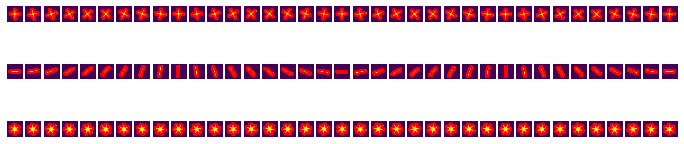

In [26]:
# Plots

im_set = np.concatenate((plus_aug, minus_aug, multiply_aug),0)
contour_set = np.concatenate((contourf_p, contourf_m, contourf_mul),0)
im_plot = im_set
fig, axes = plt.subplots(im_plot.shape[0]//len(plus_aug), len(plus_aug), figsize=(12, 3))

plotImagContour(axes, im_set, contour_set)

In [27]:
# fourier descriptors
f1 = 3
f2 = 5
f_div = 1
FD = get_fourier_descriptor(im_set, contour_set,  im_plot.shape[0]//len(plus_aug), f1, f2, f_div)

In [28]:
# labeling
labeled_array, num_features = ndimage.label(equal_aug[3])
print(num_features)
print((labeled_array==2).sum())
labeled_array, num_features = ndimage.label(divide_aug[1])
print(num_features)
print((labeled_array==2).sum())

2
11482
3
9910


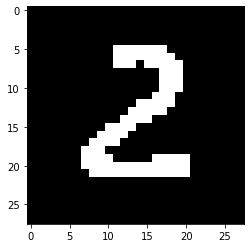

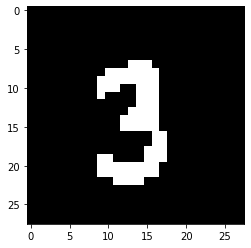

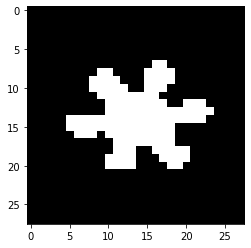

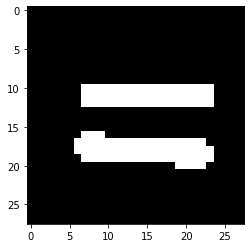

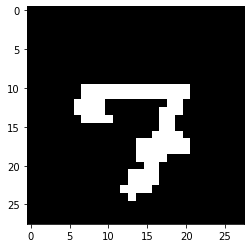

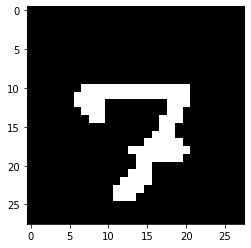

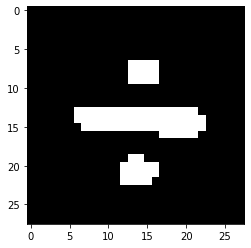

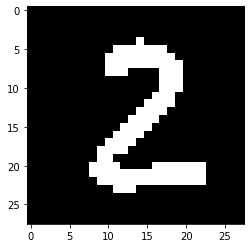

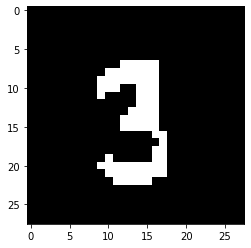

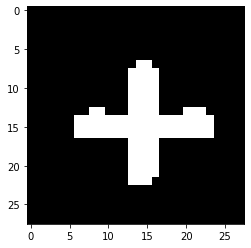

In [29]:
objects = np.load('objects.npy')
# plot images to check
for im in objects:
    plt.imshow(im, cmap = 'gray')
    plt.show()

In [30]:
objects_1 = np.array([objects[2], objects[3], objects[9]])

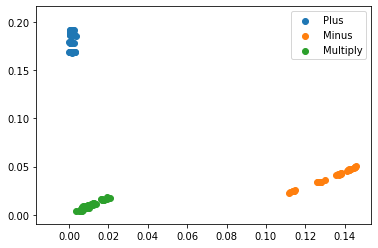

In [31]:
contourf_p = contour_fourier(plus_aug)
contourf_m = contour_fourier(minus_aug)
contourf_mul = contour_fourier(multiply_aug)
contourf_d = contour_fourier(divide_aug)
contourf_e = contour_fourier(equal_aug)

# Plots
im_set = np.concatenate((plus_aug, minus_aug, multiply_aug),0)
contour_set = np.concatenate((contourf_p, contourf_m, contourf_mul),0)
# fig, axes = plt.subplots(im_set.shape[0]//len(plus_aug), len(plus_aug), figsize=(12, 3))
# plotImagContour(axes, im_set, contour_set)

# fourier descriptors
f1 = 3
f2 = 5
f_div = 1
FD = get_fourier_descriptor(im_set, contour_set,  im_set.shape[0]//len(plus_aug), f1, f2, f_div)

for i in range(im_set.shape[0]//len(plus_aug)):
    plt.scatter(FD[i, :, 0], FD[i, :, 1])
plt.legend(['Plus', 'Minus', 'Multiply'])
plt.show()

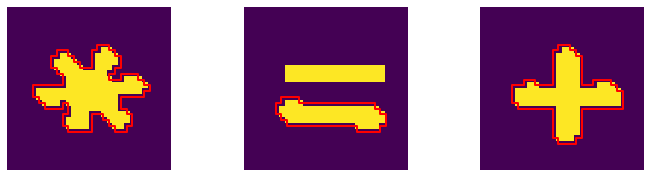

In [32]:
contourf_obj = contour_fourier(objects_1)
fig, axes = plt.subplots(objects_1.shape[0]//len(objects_1), len(objects_1), figsize=(12, 3))
plotImagContour(axes, objects_1, contourf_obj)

In [33]:
rot_step = 1
obj_set = operators_augmentation(objects_1[0], rot_step)
for i in range(1, objects_1.shape[0]):
    obj_set = np.concatenate((obj_set, operators_augmentation(objects_1[i], rot_step)),0)
    
contourf_obj_set = contour_fourier(obj_set)

# fig, axes = plt.subplots(obj_set.shape[0]//len(objects_1), len(objects_1), figsize=(40, 30))
# plotImagContour(axes, obj_set, contourf_obj_set)


In [34]:
f1 = 3
f2 = 5
f_div = 1
FD_obj = get_fourier_descriptor(obj_set, contourf_obj_set,  len(objects_1), f1, f2, f_div)


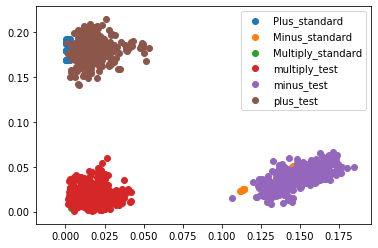

In [35]:
for i in range(im_set.shape[0]//len(plus_aug)):
    plt.scatter(FD[i, :, 0], FD[i, :, 1])

for j in range(FD_obj.shape[0]):
    plt.scatter(FD_obj[j,:,0], FD_obj[j,:,1])
plt.legend(['Plus_standard', 'Minus_standard', 'Multiply_standard',  'multiply_test', 'minus_test', 'plus_test'], loc = 'upper right')


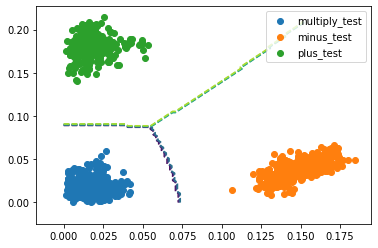

In [36]:
# train the naive bayes
from sklearn import naive_bayes
X = FD_obj.reshape(FD_obj.shape[0]*FD_obj.shape[1], FD_obj.shape[2])
y = np.concatenate((np.ones(FD_obj.shape[1]), 2*np.ones(FD_obj.shape[1]), 3*np.ones(FD_obj.shape[1])), axis=0)
clf_operator = naive_bayes.GaussianNB()
clf_operator.fit(X, y)

# use meshgrid to plot the decision boundary
N = 100 # Number of points in grid
xs, ys = np.meshgrid(np.linspace(0, 0.175, N), np.linspace(0, 0.21, N))
points = np.array([xs.ravel(), ys.ravel()]).T

# predict and classify the points in mesh grid
labels = clf_operator.predict(points).reshape(N,N)
plt.scatter(FD_obj[0,:,0],FD_obj[0,:,1])
plt.scatter(FD_obj[1,:,0],FD_obj[1,:,1])
plt.scatter(FD_obj[2,:,0],FD_obj[2,:,1])
plt.contour(xs, ys, labels, linestyles='dashed')
plt.legend(['multiply_test', 'minus_test','plus_test' ], loc = 'upper right')
plt.show()

In [37]:
from joblib import dump, load
dump(clf_operator, 'operator_classifier.joblib')

['operator_classifier.joblib']

# Classifier CNN

In [38]:
%load_ext autoreload
%autoreload 2
from classifier import CNNModel, DataGenerator
from utils import remove_9, replicate, preprocessing_mnist_data, normalize, preprocessing_our_data

Using TensorFlow backend.


## Load dataset MNIST
Reference: https://medium.com/@mjbhobe/mnist-digits-classification-with-keras-ed6c2374bd0e

In [39]:
import tarfile
import os
from sklearn import naive_bayes
import gzip
import numpy as np
import matplotlib.pyplot as plt

data_base_path = os.path.join(os.getcwd(), 'data')
data_folder = 'lab-03-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)
    
    
def extract_data(filename, image_shape, image_number):
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(np.prod(image_shape) * image_number)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(image_number, image_shape[0], image_shape[1])
    return data


def extract_labels(filename, image_number):
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * image_number)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
    return labels

image_shape = (28, 28)
train_set_size = 60000
test_set_size = 10000

data_part2_folder = os.path.join(data_base_path, data_folder, 'part2')

train_images_path = os.path.join(data_part2_folder, 'train-images-idx3-ubyte.gz')
train_labels_path = os.path.join(data_part2_folder, 'train-labels-idx1-ubyte.gz')
test_images_path = os.path.join(data_part2_folder, 't10k-images-idx3-ubyte.gz')
test_labels_path = os.path.join(data_part2_folder, 't10k-labels-idx1-ubyte.gz')

train_images = extract_data(train_images_path, image_shape, train_set_size)
test_images = extract_data(test_images_path, image_shape, test_set_size)
train_labels = extract_labels(train_labels_path, train_set_size)
test_labels = extract_labels(test_labels_path, test_set_size)
train_images.shape, train_labels.shape

((60000, 28, 28), (60000,))

In [40]:
test_digits, test_labels = remove_9(test_images, test_labels)
train_digits, train_labels = remove_9(train_images, train_labels)

train_digits.shape, train_labels.shape

((54051, 28, 28), (54051,))

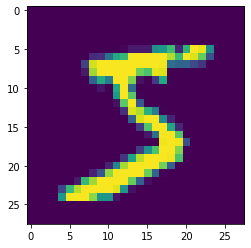

In [41]:
plt.imshow(train_digits[0])
# train_data[0, :, :, 0]

In [42]:
train_data, train_labels_cat, test_data, test_labels_cat = preprocessing_mnist_data(train_digits, train_labels, test_digits, test_labels)
train_data.shape, train_labels_cat.shape, test_data.shape, test_labels_cat.shape

((54051, 28, 28, 1), (54051, 9), (8991, 28, 28, 1), (8991, 9))

In [43]:
to_recognize_digits_operators = preprocessing_our_data(objects)
to_recognize_digits_operators.shape

(10, 28, 28)

## Create model for classify digits and operators

In [44]:
need_to_train_new_model = False
if(need_to_train_new_model):
    from keras.utils import to_categorical

    x_train = train_data
    y_train = train_labels_cat

    model = CNNModel(verbose=True)
    model.fit(x=x_train, y=y_train, epochs=40, batch_size=64)
    '''
    to use our validations image as validation set, comment the line above and decomment the following ones
    valid_img_temp = preprocessing_our_data(objects, True)
    validations_image = np.expand_dims(valid_img_temp, axis=-1)
    validations_labels = to_categorical(np.array([2, 3, 7, 7, 2, 3]), 9)
    model.fit(x=x_train, y=y_train, x_val=validations_image, y_val=validations_labels, epochs=40, batch_size=64)
    '''

## Validation with test

In [45]:
# Save model
if(need_to_train_new_model):
    test_loss, test_accuracy = model.model.evaluate(test_data, test_labels_cat, batch_size=64)
    print('Test loss: %.4f accuracy: %.4f' % (test_loss, test_accuracy))
    model.save()

In [46]:
# Load model
if(not need_to_train_new_model):
    new_model = CNNModel(verbose=False)
    new_model.load()
    test_loss, test_accuracy = new_model.model.evaluate(test_data, test_labels_cat, batch_size=64)
    print('Test loss: %.4f accuracy: %.4f' % (test_loss, test_accuracy))

8991/8991 [==============================] - 13s 1ms/step
Test loss: 0.0699 accuracy: 0.9789


## Make a prediction on our data


In [47]:
to_recognize_digits_operators = preprocessing_our_data(objects, True)
to_recognize_digits_operators.shape

(6, 28, 28)

In [48]:
# Reshape our dataset adding a dimension
predictions = new_model.model.predict(np.expand_dims(to_recognize_digits_operators, axis=-1))
preds = np.argmax(predictions, axis=1)
print(preds)
print(predictions[5])

[2 3 7 7 2 3]
[4.4303801e-05 5.7023356e-04 4.8710717e-05 9.9821031e-01 1.5560330e-05
 2.2417703e-04 1.1570389e-04 6.2853715e-04 1.4249232e-04]


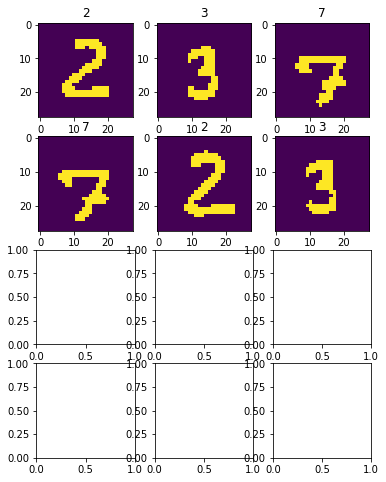

In [49]:
ax = []

images_and_predictions = list(zip(to_recognize_digits_operators, preds))
columns = 3
rows = 4
figsize = [6, 8]     # figure size, inches

fig, ax = plt.subplots(nrows=rows, ncols=columns, figsize=figsize)
for i, (axi, (image, prediction)) in enumerate(zip(ax.flat, images_and_predictions)):
    axi.imshow(image) # cmap=plt.cm.gray_r, interpolation='nearest'
    rowid = i // columns
    colid = i % columns
    axi.set_title('%i' % prediction)

(6, 28, 28, 1)
label 7


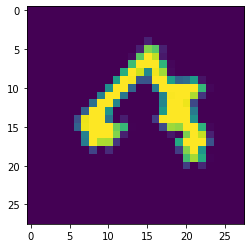

In [50]:
# Testing with rotation!


to_recognize_digits_operators_rotated = preprocessing_our_data(objects, True)
a = np.reshape(to_recognize_digits_operators_rotated, [-1, 28, 28, 1])

g = DataGenerator(a, np.array([2, 3, 7, 7, 2, 3]))
sample_x, sample_y = g[0]
print(sample_x.shape)

im = sample_x[0, :, :, 0]
label = sample_y[0]
print("label", label)

plt.imshow(im)
plt.show()
im.std(), im.mean()

# just for visualize
sample_x = sample_x.reshape((6, 28, 28))
to_recognize_digits_operators_rotated = preprocessing_our_data(sample_x, False)

In [51]:
# Reshape our dataset adding a dimension
predictions = new_model.model.predict(np.expand_dims(to_recognize_digits_operators_rotated, axis=-1))
preds = np.argmax(predictions, axis=1)
print(preds)

[7 3 2 2 7 3]


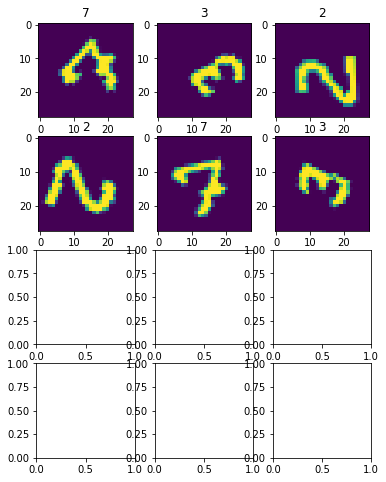

In [52]:
ax = []
images_and_predictions = list(zip(to_recognize_digits_operators_rotated, preds))
columns = 3
rows = 4
figsize = [6, 8]     # figure size, inches

fig, ax = plt.subplots(nrows=rows, ncols=columns, figsize=figsize)
for i, (axi, (image, prediction)) in enumerate(zip(ax.flat, images_and_predictions)):
    axi.imshow(image) # cmap=plt.cm.gray_r, interpolation='nearest'
    rowid = i // columns
    colid = i % columns
    axi.set_title('%i' % prediction)

label [0. 0. 0. 0. 0. 0. 0. 1. 0.]


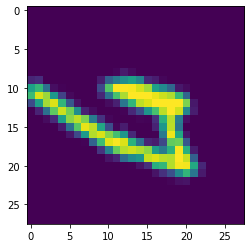

71/71 [==============================] - 12s 175ms/step
Test loss: 0.0197 accuracy: 0.9728
[7 1 4 6 5 7 1 6 7 6 6 7 4 6 7 3 2 6 7 0 0 1 0 5 7 7 7 5 4 2 0 2 0 4 0 1 0
 3 2 5 7 3 6 7 6 1 7 1 8 2 1 7 4 6 5 4 5 7 6 6 1 2 2 1 8 0 0 6 6 2 4 3 6 2
 8 8 2 2 0 3 4 5 8 7 0 5 7 5 6 3 5 8 6 1 1 5 5 1 0 5 5 0 0 6 1 1 6 8 6 2 8
 3 1 0 7 3 1 0 8 5 3 0 3 5 7 0 3 1] (128, 28, 28, 1)


In [53]:
# test with rotate digits
test_data.shape, test_labels_cat.shape

a = np.reshape(test_data, [-1, 28, 28, 1])
g = DataGenerator(a, test_labels_cat)
sample_x, sample_y = g[0]

im = sample_x[0, :, :, 0]
label = sample_y[0]
print("label", label)

plt.imshow(im)
plt.show()

test_loss, test_accuracy = new_model.model.evaluate(g)
print('Test loss: %.4f accuracy: %.4f' % (test_loss, test_accuracy))

# check visually 1 batch
predictions = new_model.model.predict(sample_x)
preds = np.argmax(predictions, axis=1)
print(preds, sample_x.shape)

In [54]:
sample_x = sample_x.reshape((sample_x.shape[0], 28, 28))

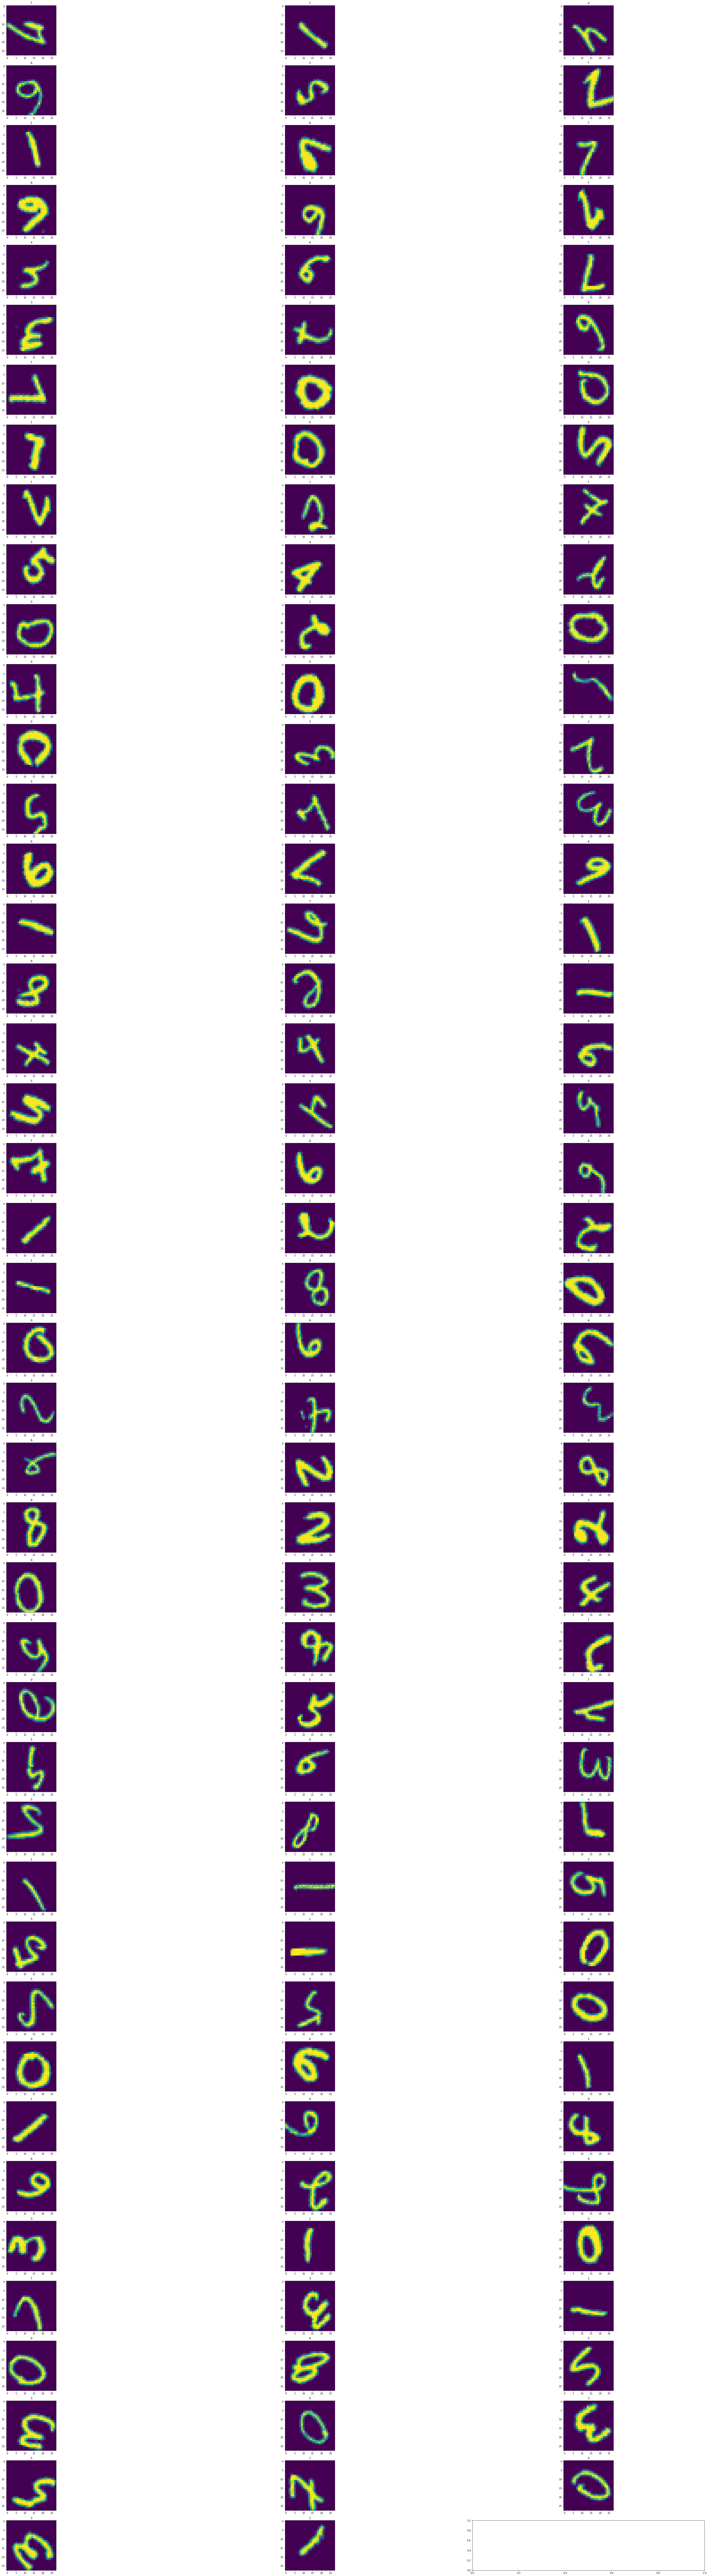

In [55]:
# just check visually
ax = []
images_and_predictions = list(zip(sample_x, preds))
# count = 0;
# idx = 0;
columns = 3
rows = 43
figsize = [60, 200]     # figure size, inches

fig, ax = plt.subplots(nrows=rows, ncols=columns, figsize=figsize)
for i, (axi, (image, prediction)) in enumerate(zip(ax.flat, images_and_predictions)):
    # i runs from 0 to (nrows*ncols-1)
    # axi is equivalent with ax[rowid][colid]
    axi.imshow(image) # cmap=plt.cm.gray_r, interpolation='nearest'
    # get indices of row/column
    rowid = i // columns
    colid = i % columns
    # write row/col indices as axes' title for identification
    axi.set_title('%i' % prediction)

In [56]:
# select number for testing
# ct = 0
# for (image, prediction) in images_and_predictions:
#     if prediction == 3:
#         ct += 1
#         if ct > 1:
#             plt.imshow(image)
#             break

        

### Combine

In [57]:
# # vedio to image
# vidcap = cv2.VideoCapture('data/project/robot_parcours_1.avi')
# def getFrame(sec):
#     vidcap.set(cv2.CAP_PROP_POS_MSEC,sec*1000)
#     hasFrame,frame = vidcap.read()
# #     if hasFrames:
# #         cv2.imwrite("data/project/image"+str(count)+".png", image)     # Uncomment to save frame as png file(lossless)
#     return hasFrame,frame
# sec = 0
# frameRate = 2 #//Frame rate = 2 FPS, it will capture image in each 0.5 second
# count=0
# hasFrame, frames = getFrame(sec)
# frames = np.expand_dims(frames[:,:,::-1],0) # Indexing to convert from BGR to RGB because matplotlib decides to do it backwards
# while hasFrame:
#     if count > 0:
#         frames = np.concatenate((frames,np.expand_dims(frame[:,:,::-1],0)),0)
#     count = count + 1
#     sec = round(count/frameRate, 2)
#     hasFrame, frame = getFrame(sec)

In [58]:
# plt.imshow(frames[0])

In [59]:
# import skimage

# # range of image
# xrange = np.arange(mask.shape[0])
# yrange = np.arange(mask.shape[1])
# # center of image
# c = [mask.shape[0]//2, mask.shape[1]//2]


# area_list = np.zeros([num_features+1,1])
# size = np.zeros([num_features+1,2])
# object_id = []
# object_center = []
# contour_list = []

    

# # calculate areas and centers, apply threshold on area to select objects of interest
# for i in range(num_features+1):
#     area = np.sum(labeled_array == i)
#     area_list[i] = area

#     if (area >= 200) & (area <= 700): # thershold by area to get objects
#         object_id.append(i)
#         object_center.append(center(labeled_array, xrange, yrange, c, i))

#     # get contours
#     temp = np.zeros_like(labeled_array)
#     temp[labeled_array == i] = 1
#     contours = skimage.measure.find_contours(temp,0.8)
#     contour = sorted(contours, key=lambda x: len(x))[-1] # get longest contour
#     contour_list.append(len(contour))
    
# print(sorted(contour_list)) # check contour length
# print(sorted(area_list)) # observe that objects of interest have areas that are one order of magnitude different from others'

In [60]:
def fourier(im):
    im = ndimage.binary_fill_holes(im) 
    im[im>0] = 255
    contours = measure.find_contours(im, 0)
    contour = sorted(contours, key=lambda x: len(x))[-1]
    
    return convert_signal(contour)

In [61]:
# Segmentation red arrow
def arrowDetect(frame_input):
    frame = frame_input.copy()
    framehsv = cv2.cvtColor(~frame, cv2.COLOR_RGB2HSV) # invert image so that red becomes cyan in HSV
    lower = np.array([90-10,80,50])
    upper = np.array([90+10,255,255])
    mask = cv2.inRange(framehsv, lower, upper)
    arrow = cv2.bitwise_and(frame,frame, mask= mask)
    # Bounding box
    contours, hierarchy = cv2.findContours(arrow[:,:,2], cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key = cv2.contourArea, reverse = True)
    c = contours[0] # longest contour
    x, y, w, h = cv2.boundingRect(c)
    cv2.circle(frame, (x+w//2,y+h//2), 5, (0,255,0),-1)
    
    return frame, (x, y, w, h) # frame with center point shown and the four bounding box parameters

In [62]:
# font = cv2.FONT_HERSHEY_SIMPLEX
# def trackArrow(frames_input):
#     cnt = 0
#     frames_output = np.zeros_like(frames_input)
#     centers = np.array([]).reshape([0,2])
#     message = ""
#     mask3 = np.zeros(len(obj_center))
#     for i, frame in enumerate(frames_input):
#         output, (x, y, w, h) = arrowDetect(frame)
#         center = np.array([x+w//2, y+h//2])
#         ind, loc, flag = get_loc(center, object_center, mask3)
#         centers = np.concatenate([centers, np.expand_dims(center,0)], 0)
#         cv2.polylines(frame_output, np.int32([centers]), False, (0,255,0), thickness = 3)
#         cv2.polylines(output, np.int32([centers]), False, (0,255,0), thickness = 3) 
#         cv2.putText(output, message, (10,450), font, 1, (0, 255, 0), 2, cv2.LINE_AA)
#         if ind:
#             mask3 = np.zeros(len(obj_center))
#             mask3[flag] = 1
#             if cnt%2 == 0:  
#                 digit = classify_digit(loc)
#                 message = message + digit  
#                 cv2.putText(output, message, (10,450), font, 1, (0, 255, 0), 2, cv2.LINE_AA)
#                 cnt+=1
#             else:
#                 operator = classify_operator(loc)
#                 message = message + operator  
#                 cv2.putText(output, message, (10,450), font, 1, (0, 255, 0), 2, cv2.LINE_AA)
#                 cnt+=1
#         frames_output[i] = output
        
#     result = eval(message[:-1])
#     message += str(result)
#     cv2.putText(output, message, (10,450), font, 1, (0, 255, 0), 2, cv2.LINE_AA)
#     frames_output = np.concatenate((frames_output, np.expand_dims(output, 0)), 0)
#     return frames_output

In [63]:

# min_d = []
# def get_loc(center, object_center, mask3): 
#     for i in range(len(object_center)):
#         min_d.append(np.sqrt(np.power(np.abs(obj_center[i,1]-center[0]),2) + np.power(np.abs(obj_center[i,0]-center[1]),2)))
#         if mask3[i] == 0:
#             if np.sqrt(np.power(np.abs(obj_center[i,1]-center[0]),2) + np.power(np.abs(obj_center[i,0]-center[1]),2)) < 40:
#                 mask3[i]=1
#                 return True, obj_center[i], i
#     return False, -1, -1

In [64]:
img = cv2.cvtColor(frames[0], cv2.COLOR_RGB2GRAY)
img = cv2.GaussianBlur(img,(5,5),0)
def get_img(cent):
    h = 28
    w = 28
    masky = (1-cv2.adaptiveThreshold(img,1,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,3))
    y = cent[0]
    x = cent[1]
    masky = masky[int(y-h//2):int(y+h//2), int(x-w//2):int(x+w//2)]
    return masky

In [65]:
def classify_digit(loc):
    image = get_img(loc)
    # 2d binary image
    arr_im = np.array([image])
    arr_im = preprocessing_our_data(arr_im)
    print(np.expand_dims(arr_im, axis=-1).shape)
    predictions = new_model.model.predict(np.expand_dims(arr_im, axis=-1))
    preds = np.argmax(predictions, axis=1)
    return str(preds[0])

In [66]:
def get_fd(im, contour, f1, f2, f_div):
    fft = np.fft.fft(contour)
    FD  = np.abs([fft[f1],fft[f2]])/np.abs(fft[f_div])  # Translaton (Exclude f0), scaling (ratio)，and rotation(amplitude) invariances
    return FD

In [67]:
def classify_operator(loc):
    im = get_img(loc)
    labeled_array, num_features = ndimage.label(im)
    if num_features > 3: # noise in data
        for i in range(1, num_features + 1):
            size = (labeled_array == i).sum()
            if size < 10: # threshold for noise
                print("size = ", size)
                num_features -= 1
    if num_features == 1:
        contourf = fourier(im)
        f1 = 3
        f2 = 5
        f_div = 1
        FD = get_fd(im, contourf, f1, f2, f_div)
        print(FD)
# 0 plus 1 minus 2 multiply
        pred = clf_operator.predict(np.array([FD]))[0]
        if pred == 1:
            return "*"
        elif pred == 2:
            return "-"
        else:
            return "+"
    elif num_features == 2:
        return "="
    else:
        return "/"

In [69]:
# Debugged. TODO: double check
font = cv2.FONT_HERSHEY_SIMPLEX

def get_loc(center, object_center, mask3): 
    min_d = []
    for i in range(len(object_center)):
        min_d.append(np.sqrt(np.power(np.abs(object_center[i][1]-center[0]),2) + np.power(np.abs(object_center[i][0]-center[1]),2)))
        if mask3[i] == 0:
            if np.sqrt(np.power(np.abs(object_center[i][1]-center[0]),2) + np.power(np.abs(object_center[i][0]-center[1]),2)) < 40:
                mask3[i]=1
                return True, object_center[i], i
    return False, -1, -1

def trackArrow(frames_input):
    cnt = 0
    frames_output = np.zeros_like(frames_input)
    centers = np.array([]).reshape([0,2])
    message = ""
    mask3 = np.zeros(len(object_center))
    for i, frame in enumerate(frames_input):
        output, (x, y, w, h) = arrowDetect(frame)
        center = np.array([x+w//2, y+h//2])
        
        ind, loc, flag = get_loc(center, object_center, mask3)
        
        centers = np.concatenate([centers, np.expand_dims(center,0)], 0)
        cv2.polylines(frame_output, np.int32([centers]), False, (0,255,0), thickness = 3)
        cv2.polylines(output, np.int32([centers]), False, (0,255,0), thickness = 3) 
        cv2.putText(output, message, (10,450), font, 1, (0, 255, 0), 2, cv2.LINE_AA)
        if ind:
            mask3 = np.zeros(len(object_center))
            mask3[flag] = 1
            if cnt%2 == 0:  
                digit = classify_digit(loc)
                message = message + digit  
                cv2.putText(output, message, (10,450), font, 1, (0, 255, 0), 2, cv2.LINE_AA)
                cnt+=1
            else:
                operator = classify_operator(loc)
                message = message + operator  
                cv2.putText(output, message, (10,450), font, 1, (0, 255, 0), 2, cv2.LINE_AA)
                cnt+=1
        frames_output[i] = output
        
    result = eval(message[:-1])
    message += str(result)
    cv2.putText(output, message, (10,450), font, 1, (0, 255, 0), 2, cv2.LINE_AA)
    frames_output = np.concatenate((frames_output, np.expand_dims(output, 0)), 0)
    return frames_output

frames_output = trackArrow(frames)

(1, 28, 28, 1)
(1, 28, 28, 1)
[0.00961872 0.19959991]
(1, 28, 28, 1)
[0.01044494 0.00503471]
(1, 28, 28, 1)


In [71]:
# print(mask3)

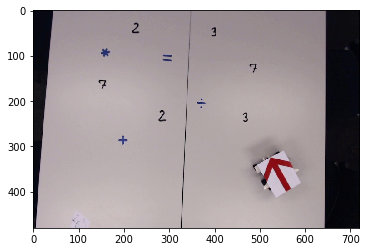

In [72]:
plt.imshow(frames[0])

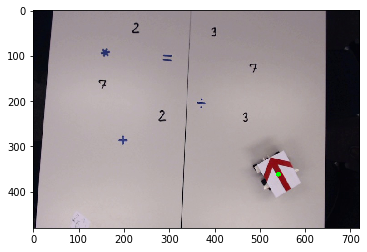

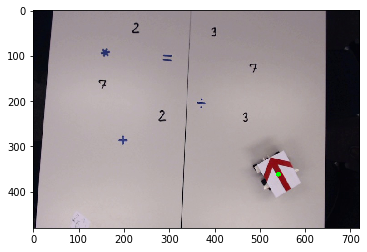

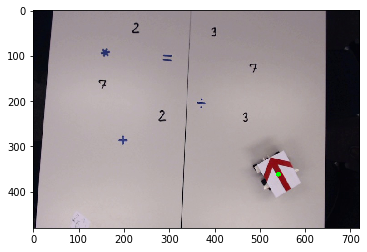

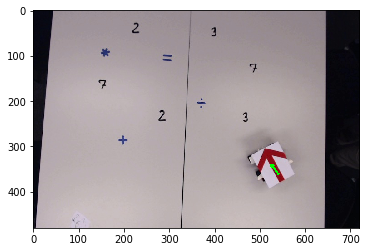

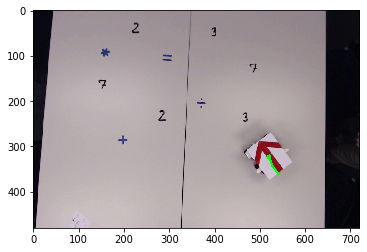

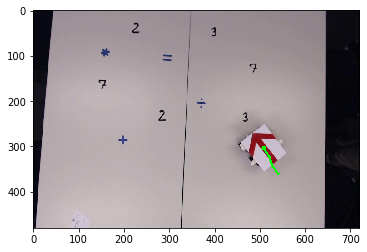

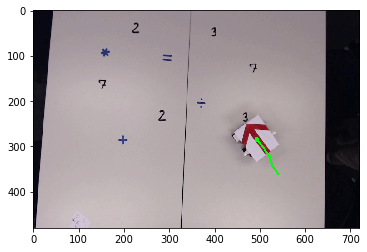

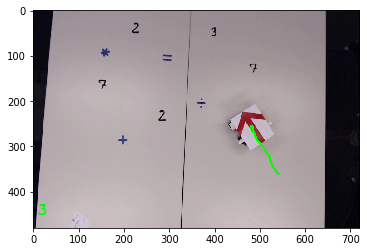

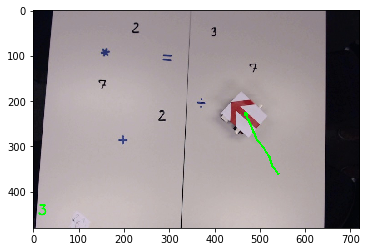

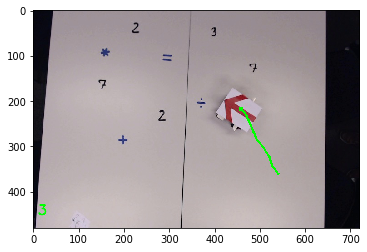

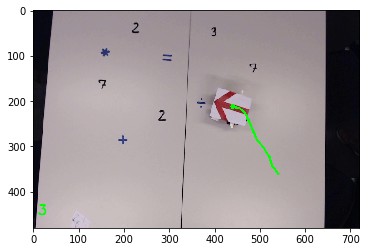

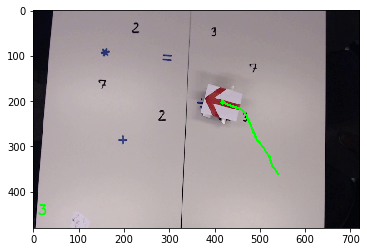

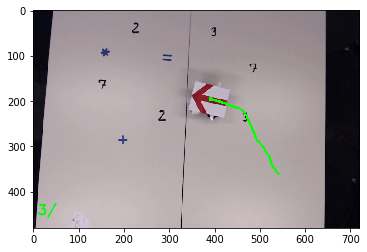

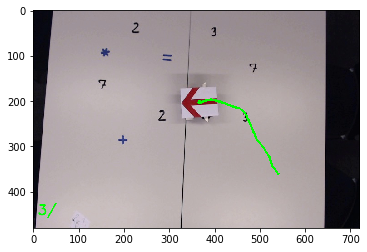

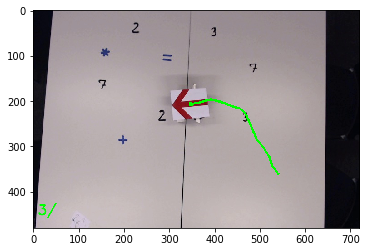

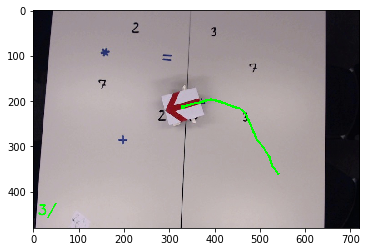

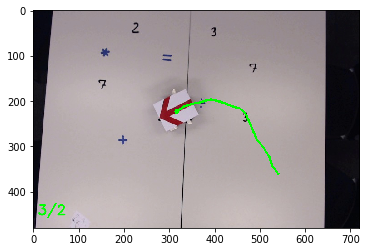

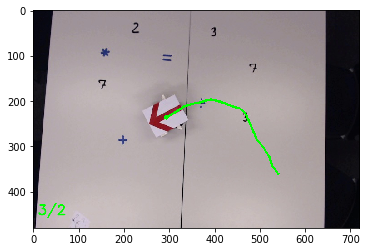

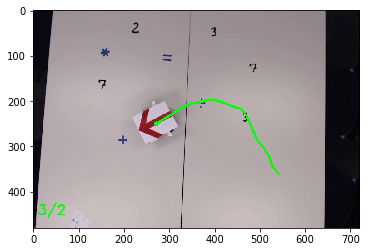

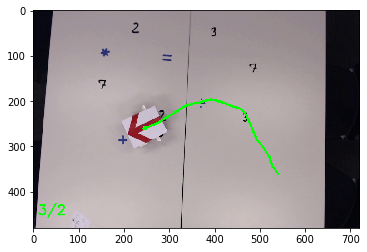

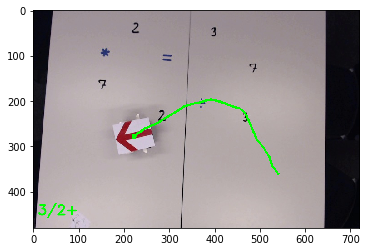

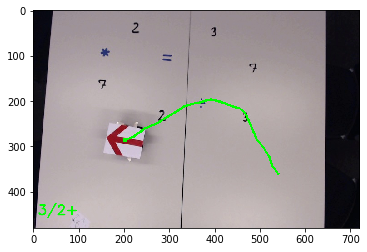

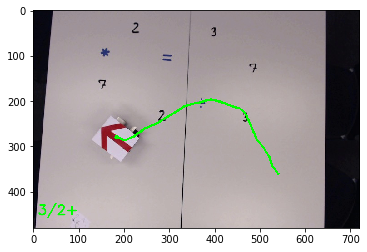

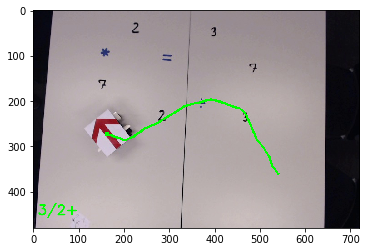

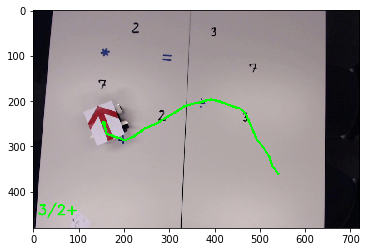

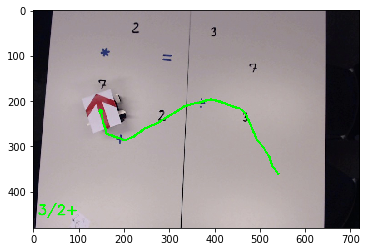

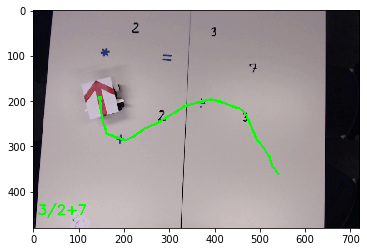

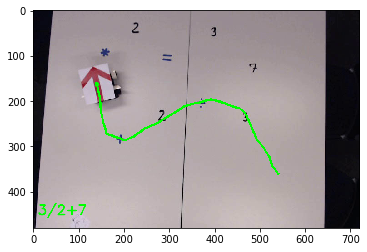

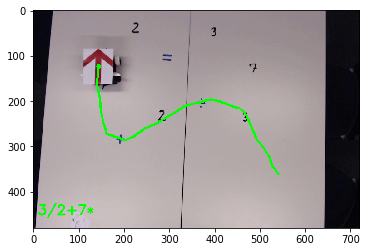

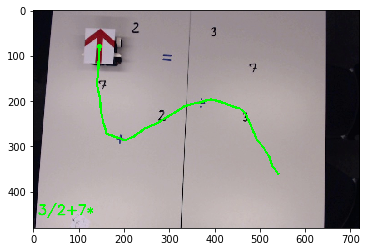

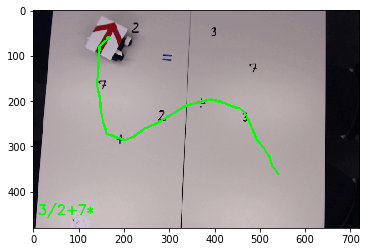

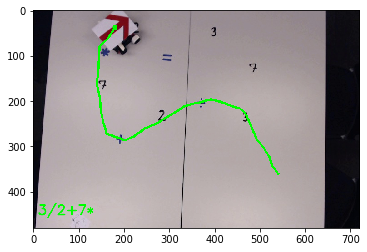

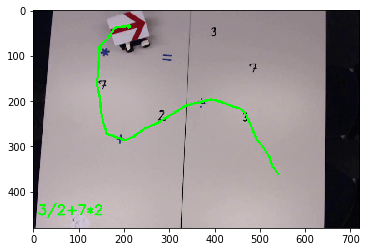

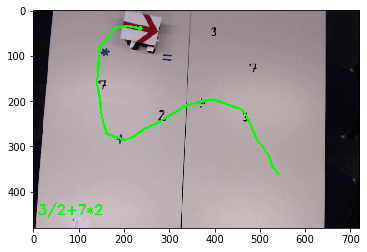

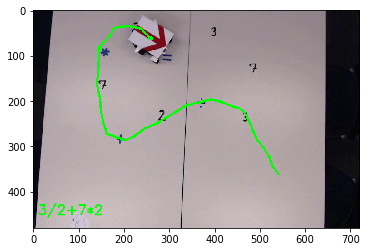

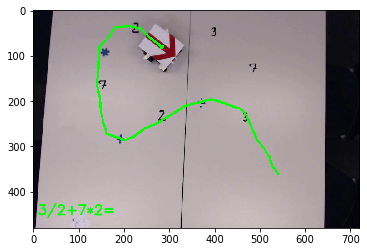

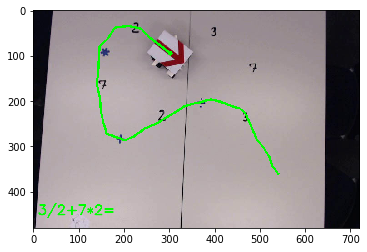

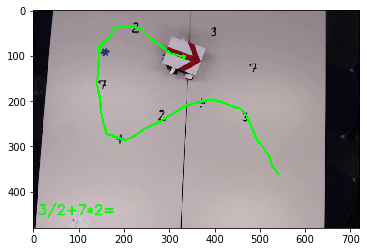

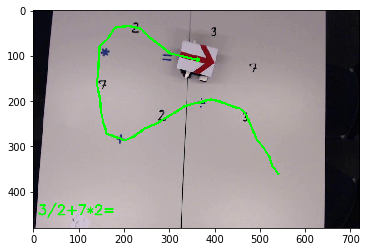

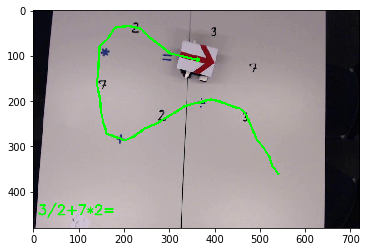

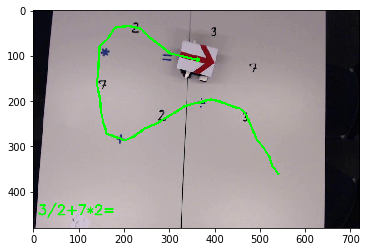

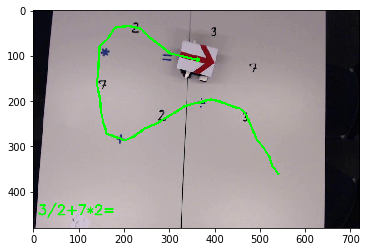

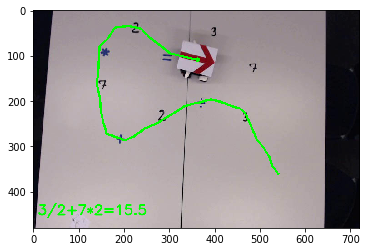

In [73]:
for frame in frames_output:
    plt.imshow(frame)
    plt.show()

In [74]:
# output video

frame_height, frame_width, _ = frame.shape

out = cv2.VideoWriter('output.avi',cv2.VideoWriter_fourcc(*'XVID'),frameRate , (frame_width,frame_height))

for frame_output in frames_output:
    out.write(frame_output[:,:,::-1])


out.release()


In [75]:
# bounding box size in the first frame
print(w, h)

64 77
